# Code to analyze neuropixel data across sleep 


Basic definition of exp parameters and query for files


In [39]:
from pinkrigs_tools.dataset.query import load_data, queryCSV
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import seaborn as sns
from scipy import stats, signal
from neuropixel_utils import *
%load_ext autoreload
%autoreload 2

SUBJECT = 'AV049'
EXP_DATE = '2023-07-27'
EXP_NUM = '2'

exp = queryCSV(
    subject=SUBJECT,
    expDate=EXP_DATE,
    expNum=EXP_NUM,
)

# 1. Define experiment parameters once
exp_kwargs = {
    'subject': [SUBJECT],
    'expDate': EXP_DATE,
    'expNum': EXP_NUM,
}


#2. Create an output directory in the DLC folder
dlc_folder = f"C:\\Users\\Experiment\\Projects\\video_conversions\\subjects\{SUBJECT}\{EXP_DATE}_{EXP_NUM}\DLC"
output_folder = os.path.join(dlc_folder, "neuropixel_analysis")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Output folder created: {output_folder}")

# define the ONE data to load:
data_name_dict = {'events':{'_av_trials':'table'}}
recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
exp_info = queryCSV(**exp_kwargs)
print(f"Analysis for: Subject {SUBJECT}, Date {EXP_DATE}, Experiment {EXP_NUM}")
print("Experiment folder:", exp_info['expFolder'].iloc[0])
print("Ephys paths:")
print("- Probe 0:", exp_info['ephysPathProbe0'].iloc[0])
print("- Probe 1:", exp_info['ephysPathProbe1'].iloc[0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Analysis for: Subject AV049, Date 2023-07-27, Experiment 2
Experiment folder: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\2
Ephys paths:
- Probe 0: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\ephys\AV049_2023-07-27_freely-moving_g0\AV049_2023-07-27_freely-moving_g0_imec0
- Probe 1: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\ephys\AV049_2023-07-27_freely-moving_g0\AV049_2023-07-27_freely-moving_g0_imec1


Load spike data


Processed probe0:
Shape of counts matrix: (798, 24635)
Time bins: 24635 bins from 0.00s to 2463.40s
Number of clusters: 798


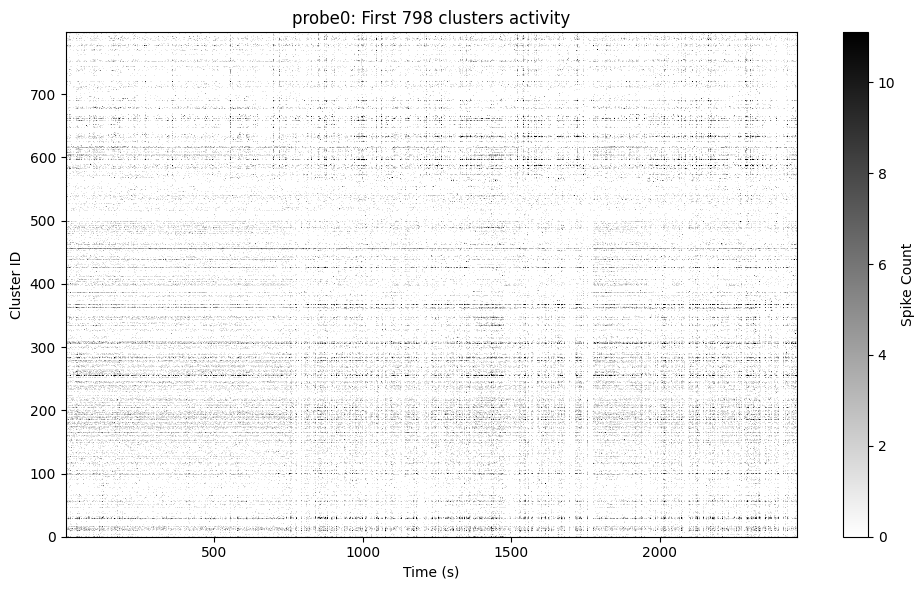


Processed probe1:
Shape of counts matrix: (690, 24635)
Time bins: 24635 bins from 0.00s to 2463.40s
Number of clusters: 690


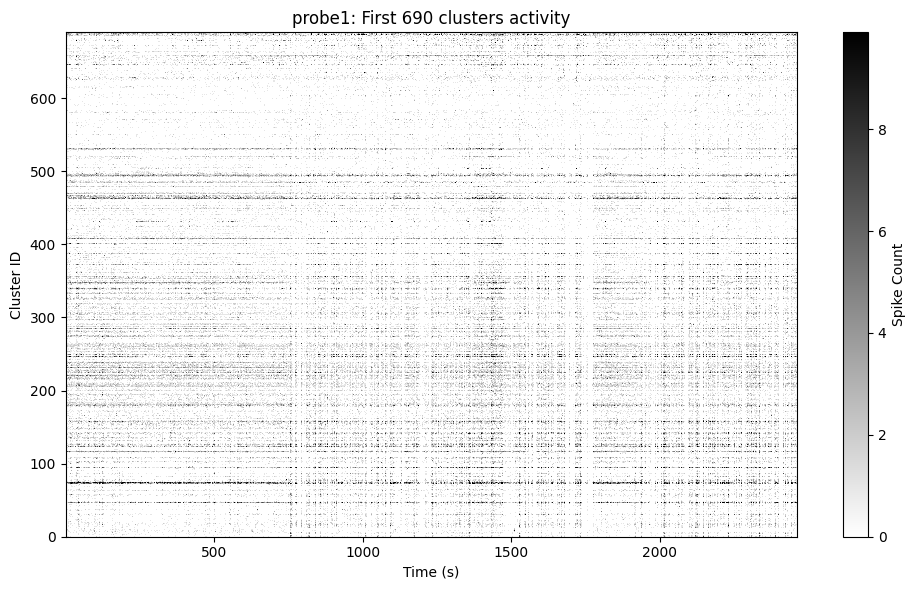


Results for probe0:
Shape of counts matrix: (798, 24635)
Number of time bins: 24635
Number of clusters: 798

Results for probe1:
Shape of counts matrix: (690, 24635)
Number of time bins: 24635
Number of clusters: 690
Available spike data fields for probe 0: ['amps', 'clusters', 'depths', 'templates', 'times', '_av_shankIDs', '_av_xpos']

Available cluster data fields for probe 0: ['amps', 'channels', 'depths', 'peakToTrough', 'waveforms', 'waveformsChannels', '_av_IDs', '_av_KSLabels', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'ks2_contamination_pct', 'ks2_label', '_av_shankID', '_av_xpos', 'maxChannels', 'phy_clusterID', 'clusterID', 'useTheseTimesStart', 'useTheseTimesStop', 'RPV_tauR_estimate', 'percentageSpikesMissing_gaussian', 'percentageSpikesMissing_symmetric', 'ksTest_pValue',

In [40]:
# Process and bin spike data
results = process_spike_data(
    exp_kwargs=exp_kwargs,
    bin_size=0.1, #
    show_plots=True,
)

# Display summary of the results
for probe in results:
    print(f"\nResults for {probe}:")
    print(f"Shape of counts matrix: {results[probe]['counts'].shape}")
    print(f"Number of time bins: {len(results[probe]['time_bins'])}")
    print(f"Number of clusters: {len(results[probe]['cluster_ids'])}")

# Only load the raw spike recordings when you need them for additional analysis
ephys_dict = {'spikes':'all','clusters':'all'}
data_name_dict = {'probe0':ephys_dict,'probe1':ephys_dict} 
spike_recordings = load_data(data_name_dict=data_name_dict, **exp_kwargs)

# If you want to examine the raw data structure
spike_data_probe0 = spike_recordings['probe0'][0]['spikes']
print("Available spike data fields for probe 0:", list(spike_data_probe0.keys()))
cluster_data_probe0 = spike_recordings['probe0'][0]['clusters']
print("\nAvailable cluster data fields for probe 0:", list(cluster_data_probe0.keys()))

Load camera data

In [41]:
# Load camera data
data_name_dict = {'topCam': {'camera': ['times']}}
camera_recordings = load_data(data_name_dict=data_name_dict, **exp_kwargs)

print("Camera recordings loaded from:", exp_info['expFolder'].iloc[0])
# Access the camera times
if 'topCam' in camera_recordings and not camera_recordings['topCam'].empty:
    topCam_data = camera_recordings['topCam'].iloc[0]
    
    if hasattr(topCam_data, 'camera') and hasattr(topCam_data.camera, 'times'):
        cam_times = topCam_data.camera.times
        
        # Print basic statistics about the camera timestamps
        print(f"Number of camera frames: {len(cam_times)}")
        print(f"First 5 timestamps: {cam_times[:5]}")
        print(f"Last 5 timestamps: {cam_times[-5:]}")
        
        first_time = cam_times[0]
        last_time = cam_times[-1]
        duration = last_time - first_time
        
        print(f"\nFirst timestamp: {first_time:.5f}")
        print(f"Last timestamp: {last_time:.5f}")
        print(f"Duration: {duration:.5f} seconds")
        
        # Calculate average frame rate
        frame_rate = (len(cam_times) - 1) / duration
        print(f"Average frame rate: {frame_rate:.2f} frames per second")
    else:
        print("Error: 'times' attribute not found in camera data")
else:
    print("Error: No topCam data found in the recordings")

Camera recordings loaded from: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\2
Number of camera frames: 144500
First 5 timestamps: [-8.05320018 -8.03653335 -8.01986652 -8.0031997  -7.98653287]
Last 5 timestamps: [2400.2199261  2400.23659293 2400.25325975 2400.26992658 2400.28659341]

First timestamp: -8.05320
Last timestamp: 2400.28659
Duration: 2408.33979 seconds
Average frame rate: 60.00 frames per second


In [42]:
# Import the bombcell_sort_units function
from pinkrigs_tools.utils.spk_utils import bombcell_sort_units

# Apply Bombcell classification to each probe
for probe in results:
    if probe in spike_recordings and len(spike_recordings[probe]) > 0:
        cluster_data = spike_recordings[probe][0]['clusters']
        cluster_quality = bombcell_sort_units(cluster_data)
        results[probe]['cluster_quality'] = cluster_quality
        results[probe]['good_cluster_mask'] = np.array([q == 'good' for q in cluster_quality])
        results[probe]['good_mua_cluster_mask'] = np.array([q in ['good', 'mua'] for q in cluster_quality])
        
        # Print summary
        unique_qualities, counts = np.unique(cluster_quality, return_counts=True)
        print(f"\nBombcell classification for {probe}:")
        for quality, count in zip(unique_qualities, counts):
            print(f"- {quality}: {count} clusters")
            
        # Add a boolean mask for good clusters to results for easy filtering
        results[probe]['good_cluster_mask'] = np.array([q == 'good' for q in cluster_quality])
        
        print(f"Total clusters: {len(cluster_quality)}")
        print(f"Good+MUA clusters: {np.sum(results[probe]['good_mua_cluster_mask'])} ({np.sum(results[probe]['good_mua_cluster_mask'])/len(cluster_quality)*100:.1f}%)")



Bombcell classification for probe0:
- good: 204 clusters
- mua: 183 clusters
- noise: 411 clusters
Total clusters: 798
Good+MUA clusters: 387 (48.5%)

Bombcell classification for probe1:
- good: 151 clusters
- mua: 203 clusters
- noise: 336 clusters
Total clusters: 690
Good+MUA clusters: 354 (51.3%)


## Select Sleep Periods based on Power Bands 

Provides moving average and Savitzky-Golay filtering; select one to be saved to "sleep_times.csv" in the neuropixel output folder. 

In [43]:
freq_results = process_spike_data(
    exp_kwargs=exp_kwargs,
    bin_size=0.005,  # 200Hz sampling rate
    show_plots=False  
)


# Apply Bombcell classification to each probe
for probe in freq_results:
    if probe in spike_recordings and len(spike_recordings[probe]) > 0:
        cluster_data = spike_recordings[probe][0]['clusters']
        cluster_quality = bombcell_sort_units(cluster_data)
        freq_results[probe]['cluster_quality'] = cluster_quality
        freq_results[probe]['good_cluster_mask'] = np.array([q == 'good' for q in cluster_quality])
        freq_results[probe]['good_mua_cluster_mask'] = np.array([q in ['good', 'mua'] for q in cluster_quality])
        unique_qualities, counts = np.unique(cluster_quality, return_counts=True)
        print(f"\nBombcell classification for {probe}:")
        for quality, count in zip(unique_qualities, counts):
            print(f"- {quality}: {count} clusters")
            
        print(f"Total clusters: {len(cluster_quality)}")
        print(f"Good+MUA clusters: {np.sum(freq_results[probe]['good_mua_cluster_mask'])} ({np.sum(freq_results[probe]['good_mua_cluster_mask'])/len(cluster_quality)*100:.1f}%)")



Processed probe0:
Shape of counts matrix: (798, 492672)
Time bins: 492672 bins from 0.00s to 2463.36s
Number of clusters: 798

Processed probe1:
Shape of counts matrix: (690, 492673)
Time bins: 492673 bins from 0.00s to 2463.36s
Number of clusters: 690

Bombcell classification for probe0:
- good: 204 clusters
- mua: 183 clusters
- noise: 411 clusters
Total clusters: 798
Good+MUA clusters: 387 (48.5%)

Bombcell classification for probe1:
- good: 151 clusters
- mua: 203 clusters
- noise: 336 clusters
Total clusters: 690
Good+MUA clusters: 354 (51.3%)


In [44]:
spectrum_results = analyze_power_spectrum(
    results=freq_results,
    output_dir=output_folder,
    save_plots=False,
    show_plots=False,
    nperseg=200,
    noverlap=150,
    freq_range=(0, 50), 
    sleep_bouts=None,
    use_quality_filter=True,
)

Sampling rate: 200.0Hz (bin_size=0.0050s)
Maximum detectable frequency: 100.0Hz
Filtered probe0: kept 387 of 798 clusters
Probe probe0: Selected 387 clusters ('good' and 'mua') out of 798
Filtered probe1: kept 354 of 690 clusters
Probe probe1: Selected 354 clusters ('good' and 'mua') out of 690
Merged 741 clusters from 2 probes
Using 492672 time bins (truncated to match across probes)


Loaded 17 behavioral sleep bouts for comparison
Time step: 0.24997s, minimum sleep duration: 10s (40 samples)

Behavioral Sleep Statistics:
- 17 sleep bouts
- Total sleep time: 1309.3s (53.2% of recording)

Moving Average Sleep Detection (threshold=-48dB, min duration=10s):
- Detected 10 sleep bouts
- Total sleep time: 1248.0s (50.7% of recording)
- Comparison to behavioral sleep:
  * Precision: 0.90 (proportion of detected sleep that matches behavior)
  * Recall: 0.86 (proportion of behavioral sleep that was detected)
  * IoU: 0.78 (Intersection over Union)

Savitzky-Golay Sleep Detection (threshold=-49dB, min duration=10s):
- Detected 12 sleep bouts
- Total sleep time: 1279.5s (52.0% of recording)
- Comparison to behavioral sleep:
  * Precision: 0.88 (proportion of detected sleep that matches behavior)
  * Recall: 0.86 (proportion of behavioral sleep that was detected)
  * IoU: 0.77 (Intersection over Union)


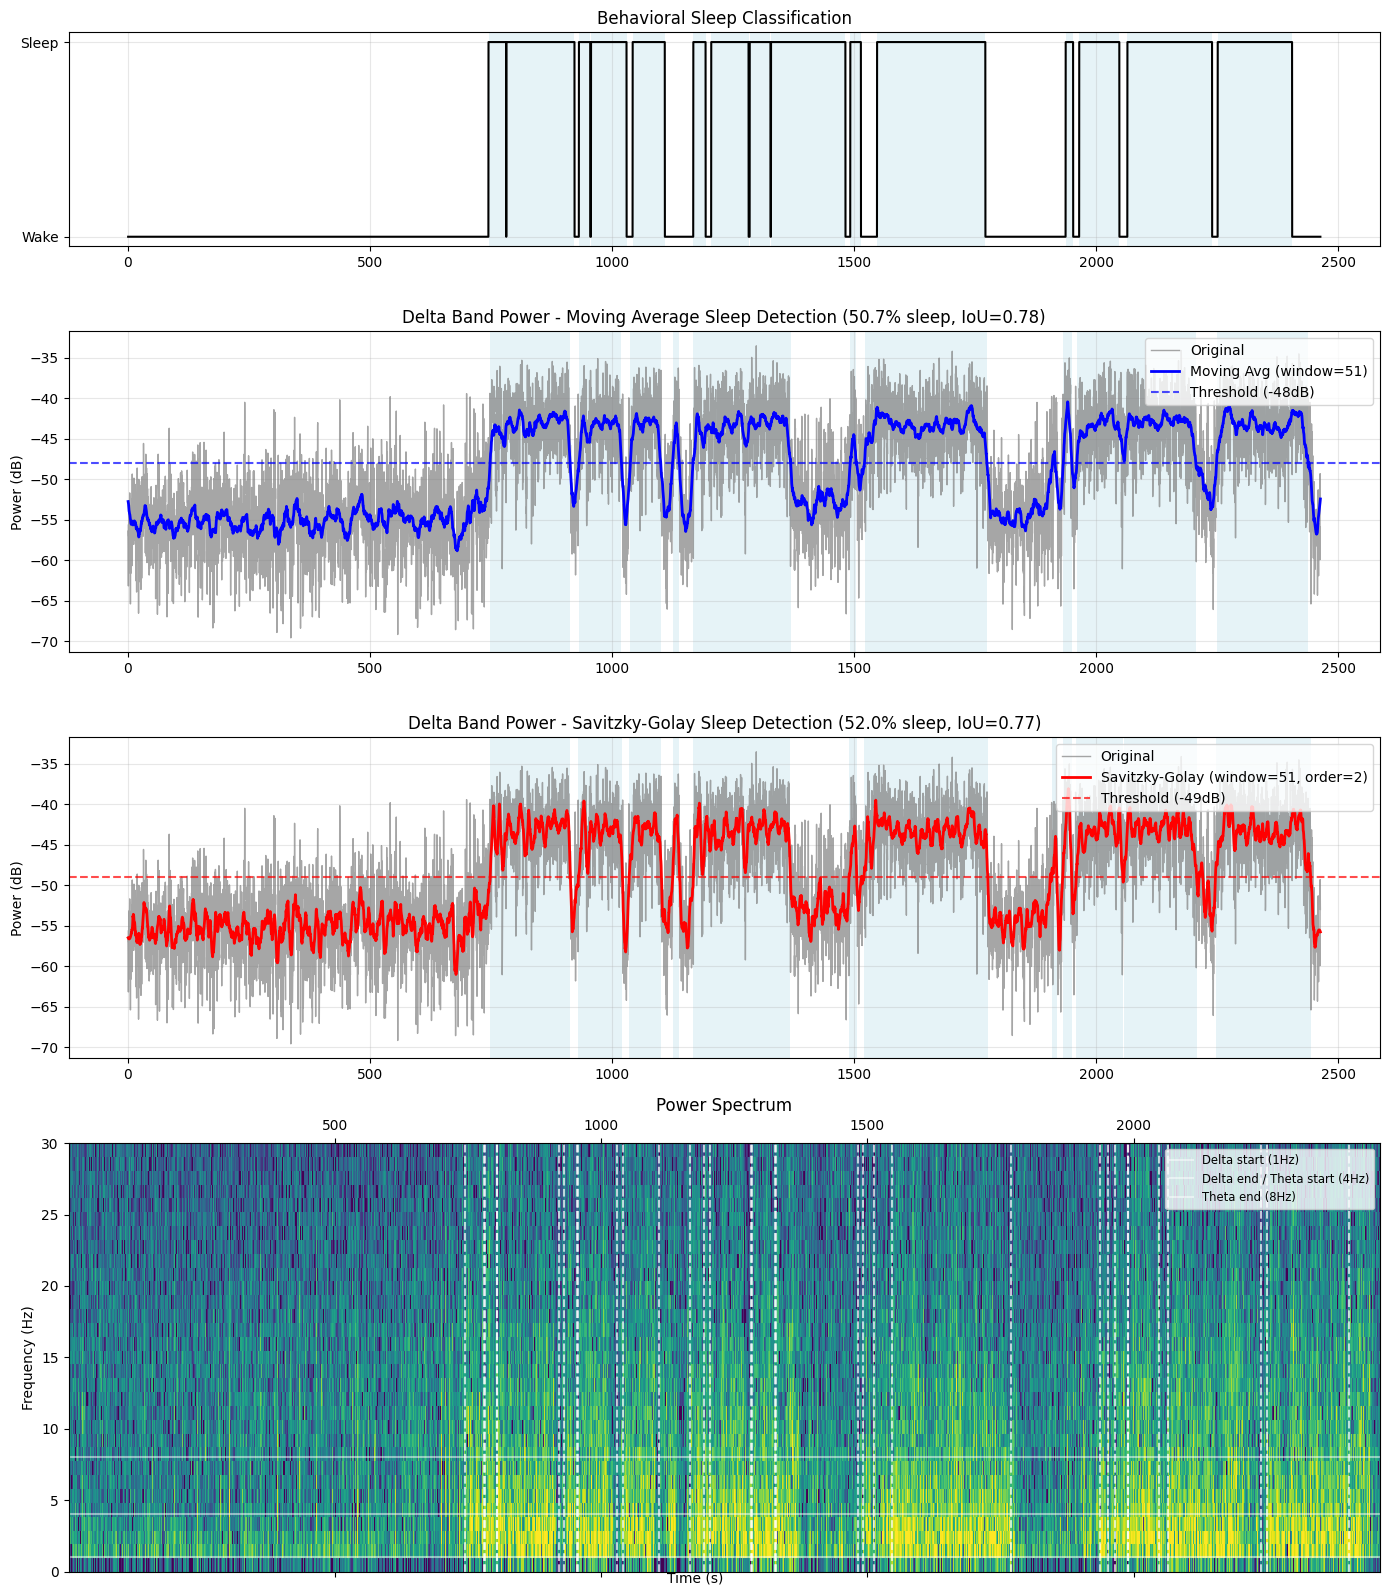

Moving Average Sleep Periods:
   start_time  end_time  duration          method
0      747.75    913.25    165.50  Moving Average
1      931.50   1019.00     87.50  Moving Average
2     1037.75   1100.25     62.50  Moving Average
3     1124.75   1138.75     14.00  Moving Average
4     1167.00   1368.75    201.75  Moving Average
5     1491.75   1504.50     12.75  Moving Average
6     1521.50   1774.00    252.50  Moving Average
7     1932.00   1949.25     17.25  Moving Average
8     1960.00   2205.25    245.25  Moving Average
9     2248.25   2437.25    189.00  Moving Average

Savitzky-Golay Sleep Periods:
    start_time  end_time  duration          method
0       748.25    913.75    165.50  Savitzky-Golay
1       930.50   1021.25     90.75  Savitzky-Golay
2      1035.50   1101.75     66.25  Savitzky-Golay
3      1125.25   1139.00     13.75  Savitzky-Golay
4      1167.75   1368.00    200.25  Savitzky-Golay
5      1489.25   1505.00     15.75  Savitzky-Golay
6      1520.25   1775.75    255.

In [47]:
beh_sleep_csv = os.path.join(dlc_folder, r"pixel_difference\sleep_times.csv")
if os.path.exists(beh_sleep_csv):
    beh_df_sleep = pd.read_csv(beh_sleep_csv)
    if beh_df_sleep.shape[0] == 0:
        print("Warning: Behavioral sleep CSV exists but contains no sleep bouts")
        beh_df_sleep = None
    else:
        print(f"Loaded {len(beh_df_sleep)} behavioral sleep bouts for comparison")
        if 'start_time_s' in beh_df_sleep.columns and 'end_time_s' in beh_df_sleep.columns:
            beh_df_sleep = beh_df_sleep.rename(columns={
                'start_time_s': 'start_timestamp_s',
                'end_time_s': 'end_timestamp_s'
        })
    
smoothed_results = power_band_smoothing(
    spectrum_results=spectrum_results,
    window_size=51,
    poly_order=2,
    threshold_ma=-48,
    threshold_sg=-49,
    min_duration_s=10,
    output_dir=output_folder,
    df_sleep=beh_df_sleep,
    save_plots=False, 
)

print("Moving Average Sleep Periods:")
print(smoothed_results['sleep_df_ma'])

print("\nSavitzky-Golay Sleep Periods:")
print(smoothed_results['sleep_df_sg'])

In [48]:
neural_sleep_csv = save_sleep_periods_to_csv(
    smoothed_results=smoothed_results, 
    output_dir=output_folder,
    used_filter='MA', # or 'MA' for moving average
    frame_rate=60
)

df_neural_sleep = pd.read_csv(neural_sleep_csv)


Saved detected sleep periods to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\sleep_times.csv
Total sleep periods: 10
Total sleep time: 1248.0 seconds
Frames calculated using frame rate of 60 fps
Frame range: 44866-146236


Align sleep data to the camera data and add timestamps to the csv file. 

In [49]:
results = map_sleep_bouts_to_neural_data(results, neural_sleep_csv, cam_times)
freq_results = map_sleep_bouts_to_neural_data(freq_results, neural_sleep_csv, cam_times)


Alignment information for probe0:
- Camera time range: -8.05s to 2400.29s
- Neural time range: 0.00s to 2463.40s
- Automatic time offset: 8.05s
  (Adding 8.05s to camera timestamps to align with neural data)

Sleep bout mapping for probe0:
- Time bins range: 0.00s to 2463.40s
- Bin size: 0.10s
- Total bins: 24635
- Number of sleep bouts: 10
- Sleep bouts within neural recording range: 10

Sample mapping (first 5 bouts):
   start_timestamp_s  aligned_start_timestamp_s  start_bin_time  \
0             747.75                   755.8032      755.800133   
1             931.50                   939.5532      939.600133   
2            1037.75                  1045.8032     1045.800133   
3            1124.75                  1132.8032     1132.800133   
4            1167.00                  1175.0532     1175.100133   

   end_timestamp_s  aligned_end_timestamp_s  end_bin_time  duration_s  \
0           913.25                 921.3032    921.300133      165.50   
1          1019.00        

Filter clusters by "good" and "mua" based on bombcell sorting and plot:

    1. The average firing rate of all units across the recording with sleep times highlighted
    2. The average activity of the 10 clusters with highest difference between average firing in sleep periods - average firing in wake periods (highest/lowest 10 clusters shown)


Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters

Results for merged probes:

Top 10 sleep-selective clusters:
  1. probe0 Cluster 443: Modulation = -0.8606 (Sleep: 0.2418 Hz, Wake: 0.0181 Hz)
  2. probe0 Cluster 466: Modulation = -0.8131 (Sleep: 0.3035 Hz, Wake: 0.0313 Hz)
  3. probe0 Cluster 323: Modulation = -0.7937 (Sleep: 0.2362 Hz, Wake: 0.0272 Hz)
  4. probe0 Cluster 91: Modulation = -0.7778 (Sleep: 0.2306 Hz, Wake: 0.0288 Hz)
  5. probe1 Cluster 396: Modulation = -0.7691 (Sleep: 0.7887 Hz, Wake: 0.1029 Hz)
  6. probe0 Cluster 404: Modulation = -0.7632 (Sleep: 0.2146 Hz, Wake: 0.0288 Hz)
  7. probe0 Cluster 74: Modulation = -0.7549 (Sleep: 0.1946 Hz, Wake: 0.0272 Hz)
  8. probe0 Cluster 70: Modulation = -0.7495 (Sleep: 0.1265 Hz, Wake: 0.0181 Hz)
  9. probe0 Cluster 414: Modulation = -0.7438 (Sleep: 0.6446 Hz, Wake: 0.0947 Hz)
  10. probe0 Cluster 75: Modulation = -0.7013 (Sleep: 0.5533 Hz, Wake: 0.0972 Hz)

Top 10 wake-selective clusters:
  1.

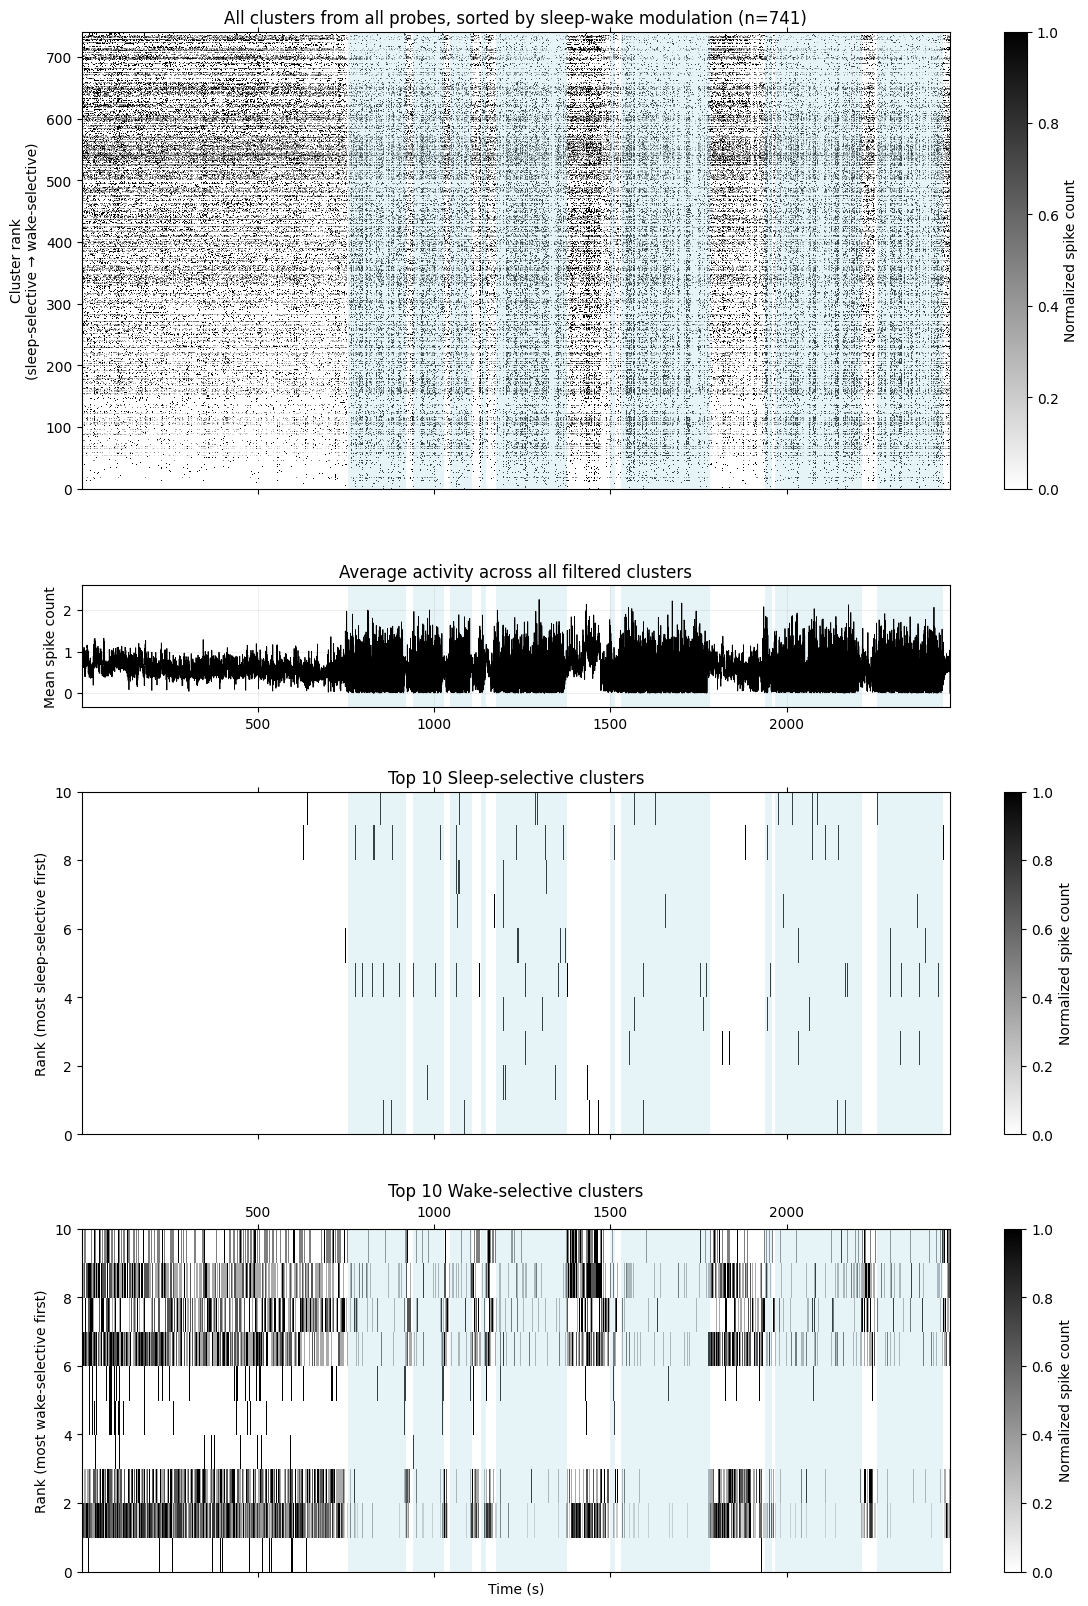

In [50]:
np_results = analyze_sleep_wake_activity(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    num_top_clusters=10
)

Looking at the frequency across the recording

Loaded behavioral data from C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\pixel_difference\2023-07-27_2_AV049_topCam_pixel_differences.csv
Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters
Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters
Using Moving Average filter for frequency band visualization
Saved combined plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\combined_sleep_wake_spectrum_analysis_20250527_155757.png


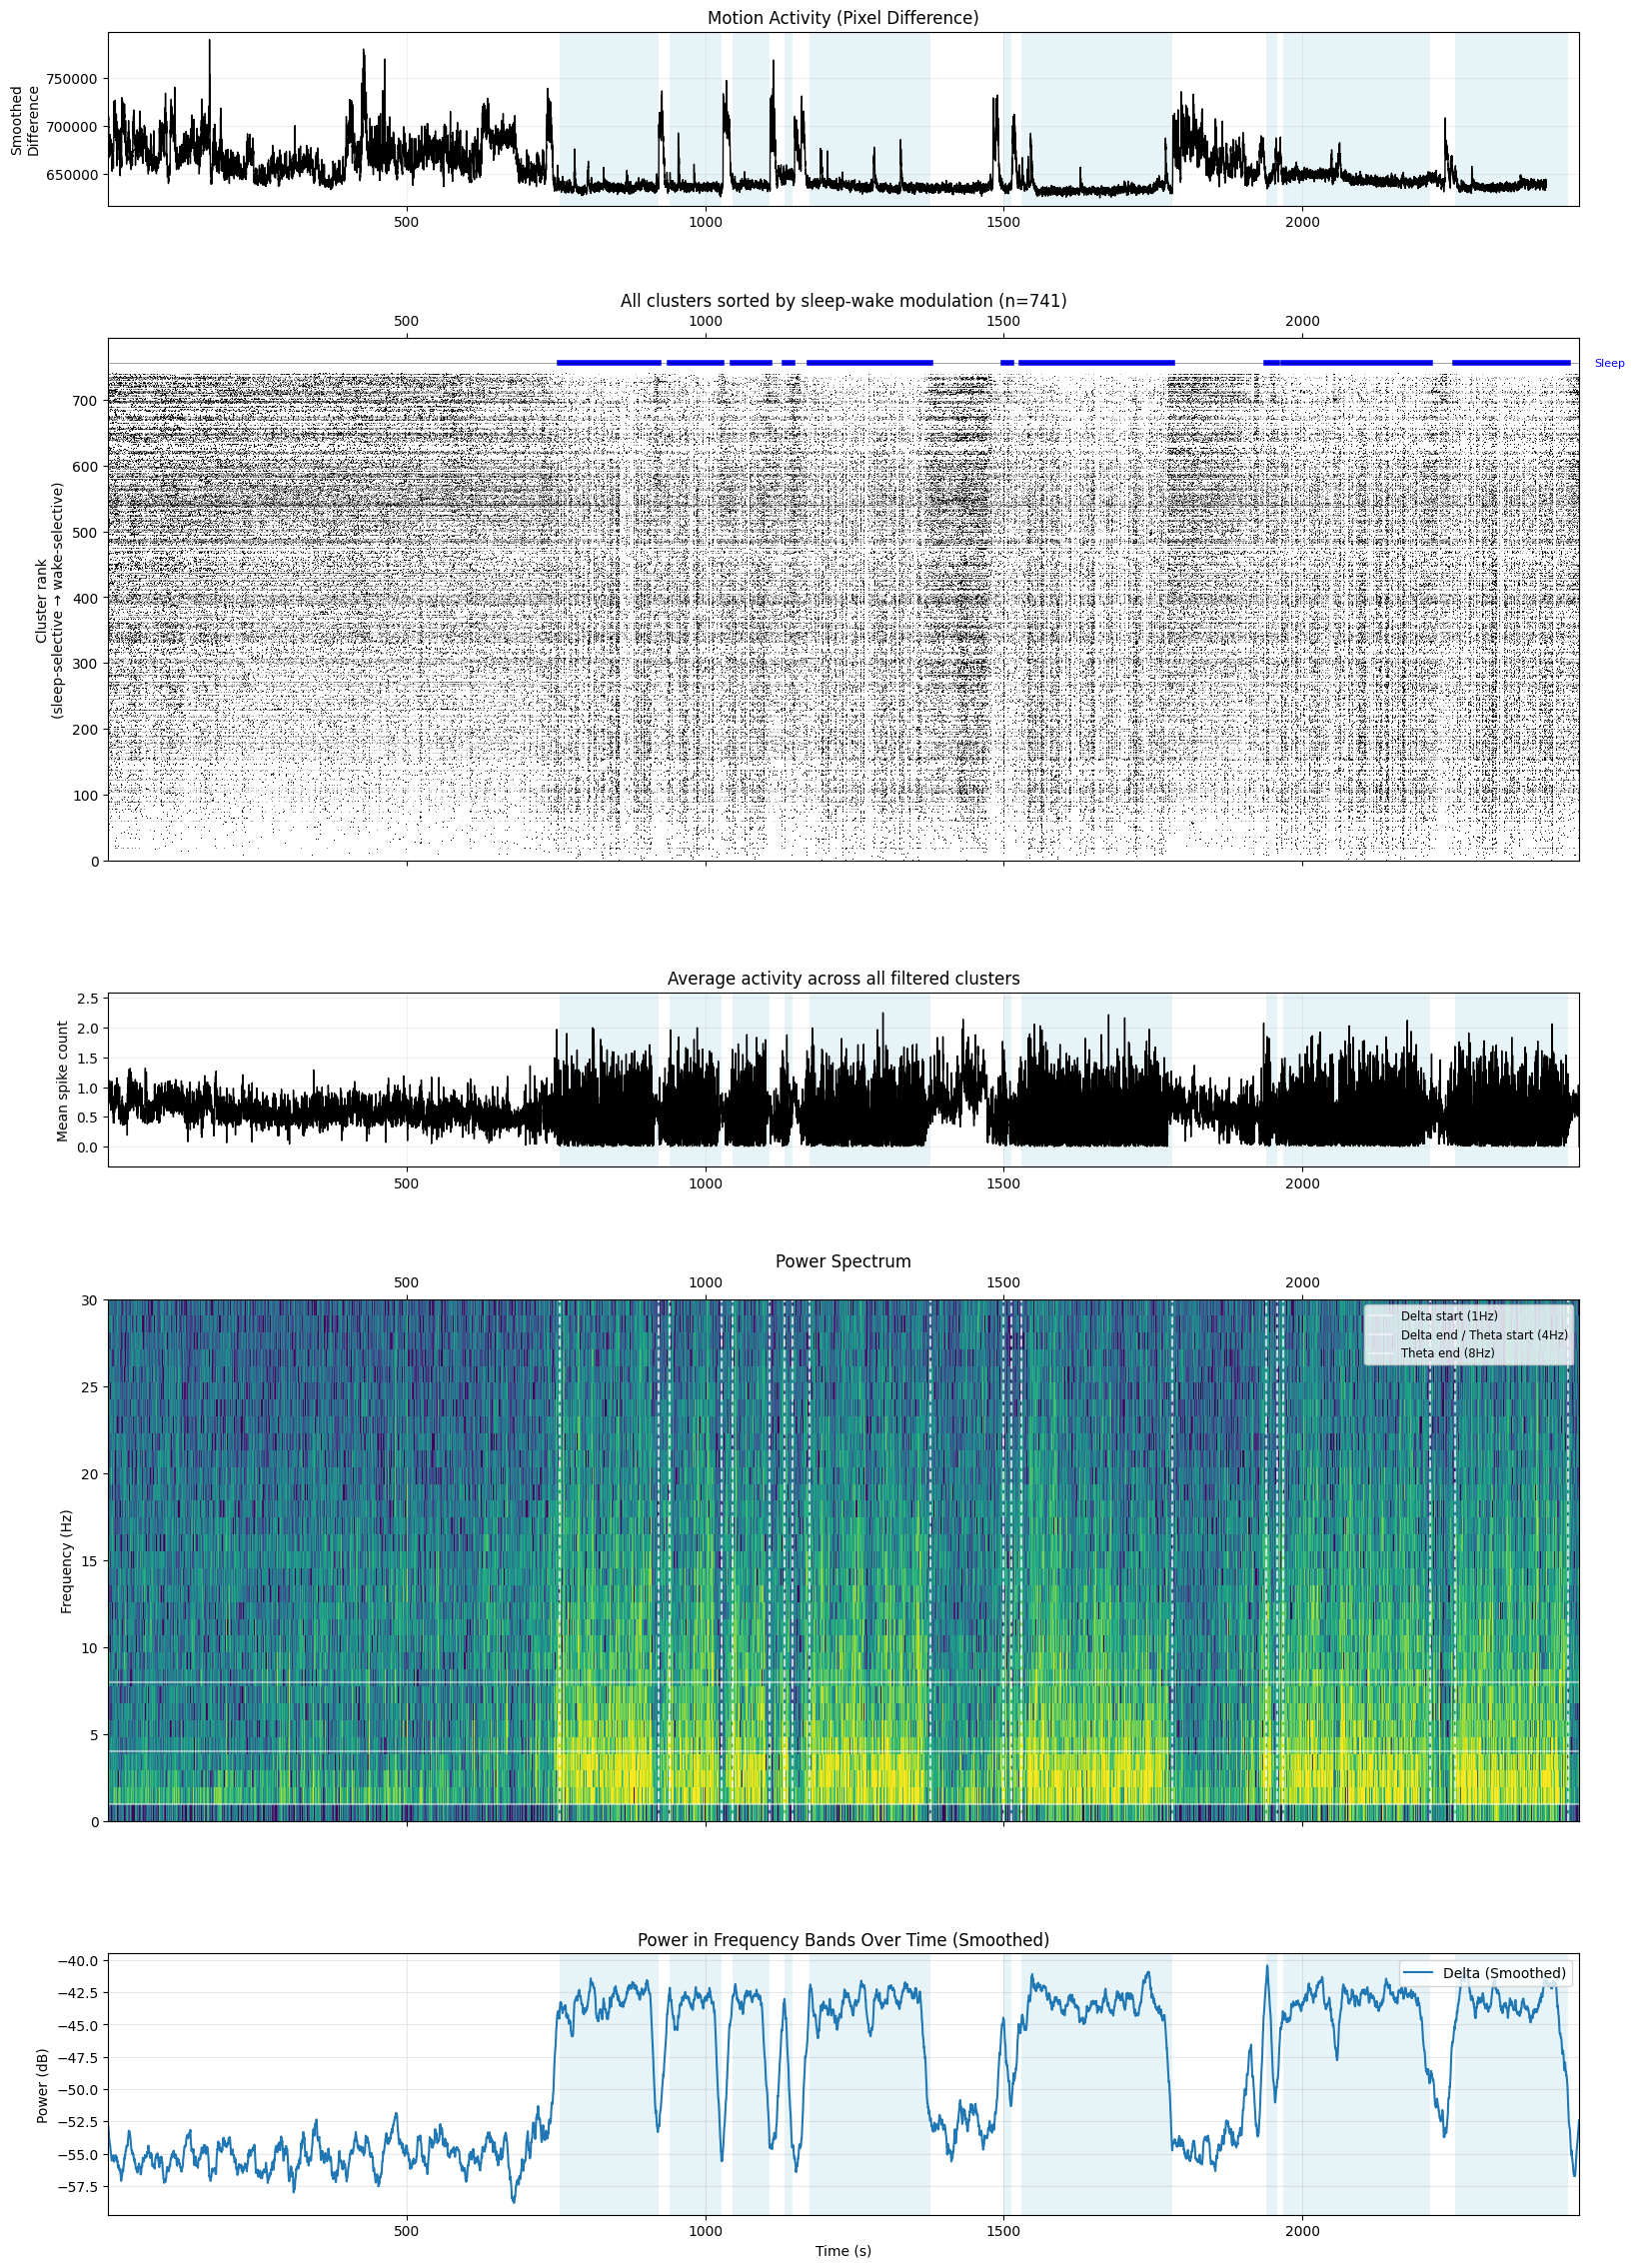

In [51]:
combined_visualization(
    results=results,
    freq_results=freq_results,
    np_results=np_results,
    spectrum_results=spectrum_results,
    dlc_folder=dlc_folder,
    output_dir=output_folder,
    save_plots=True,
    smoothed_results=smoothed_results,
)

Save the 200Hz cluster data into a npy file for rastermap - pooled all "good" & "mua" clusters across both probes

In [53]:
import numpy as np
import os

# Extract and combine good/MUA neurons from both probes
probe0_matrix = freq_results['probe0']['counts'][freq_results['probe0']['good_mua_cluster_mask'], :]
probe1_matrix = freq_results['probe1']['counts'][freq_results['probe1']['good_mua_cluster_mask'], :]
min_timepoints = min(probe0_matrix.shape[1], probe1_matrix.shape[1])
probe0_matrix = probe0_matrix[:, :min_timepoints]
probe1_matrix = probe1_matrix[:, :min_timepoints]
combined_matrix = np.vstack((probe0_matrix, probe1_matrix))

# Convert to float32 before saving (this is what's missing)
combined_matrix = combined_matrix.astype(np.float32)

# Save to NPY file
output_file = os.path.join(output_folder, f"{SUBJECT}_{EXP_DATE}_{EXP_NUM}_combined_neural_matrix.npy")
np.save(output_file, combined_matrix)

print(f"Saved combined matrix with shape {combined_matrix.shape} to {output_file}")

Saved combined matrix with shape (741, 492672) to C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\AV049_2023-07-27_2_combined_neural_matrix.npy


Bin the entire recording (standard: 120s bins) and sort them into sleep/wake based of majority of state in each bin (standard: 90% of one state as cutoff)


Filtered probe0: kept 149 of 310 clusters

First few rows of DataFrame for probe0:
   cluster_id  state  firing_rate
0           3  Sleep     0.825000
1           3   Wake     1.057222
2           4  Sleep     0.152083
3           4   Wake     0.777222
4           8  Sleep     2.575000
Saved plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-08-08_2\DLC\neuropixel_analysis\probe0_state_firing_rates_20250527_134338.png

Results for probe0 using 120s bins and 90.0% state threshold:
Total large bins: 23
Sleep bins: 4
Wake bins: 15
Mixed bins: 4

Firing rate statistics:
Sleep: median=2.0417 Hz, mean=4.8213 Hz
Wake: median=3.2878 Hz, mean=6.7666 Hz
Mann-Whitney U test: p=0.0024


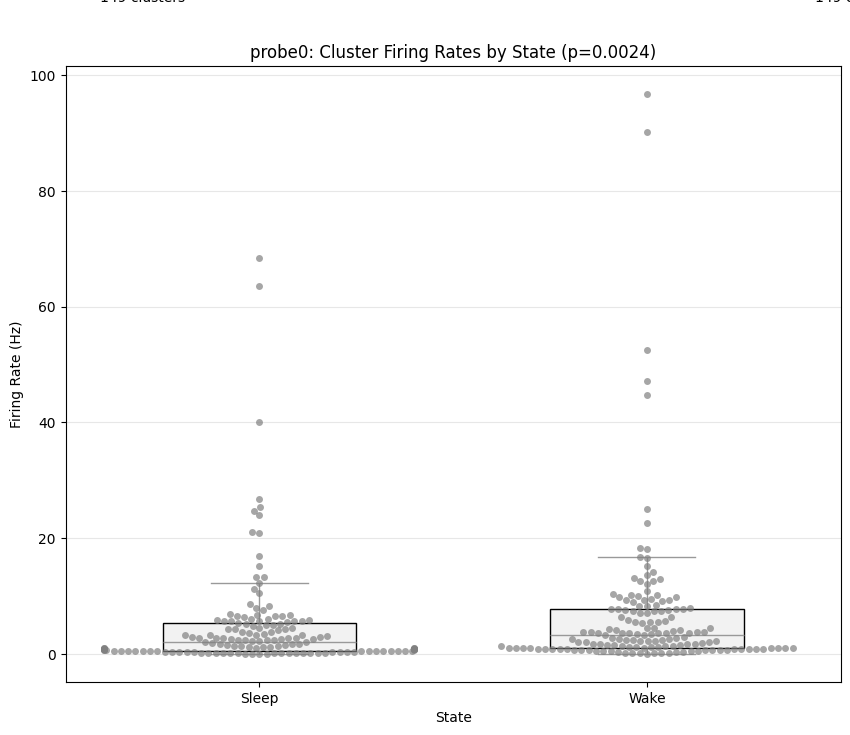

Filtered probe1: kept 132 of 268 clusters

First few rows of DataFrame for probe1:
   cluster_id  state  firing_rate
0          10  Sleep     2.083333
1          10   Wake     0.485556
2          11  Sleep     0.720833
3          11   Wake     1.943333
4          12  Sleep     0.910417
Saved plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-08-08_2\DLC\neuropixel_analysis\probe1_state_firing_rates_20250527_134340.png

Results for probe1 using 120s bins and 90.0% state threshold:
Total large bins: 23
Sleep bins: 4
Wake bins: 15
Mixed bins: 4

Firing rate statistics:
Sleep: median=1.6677 Hz, mean=3.6233 Hz
Wake: median=2.2714 Hz, mean=4.9348 Hz
Mann-Whitney U test: p=0.0300


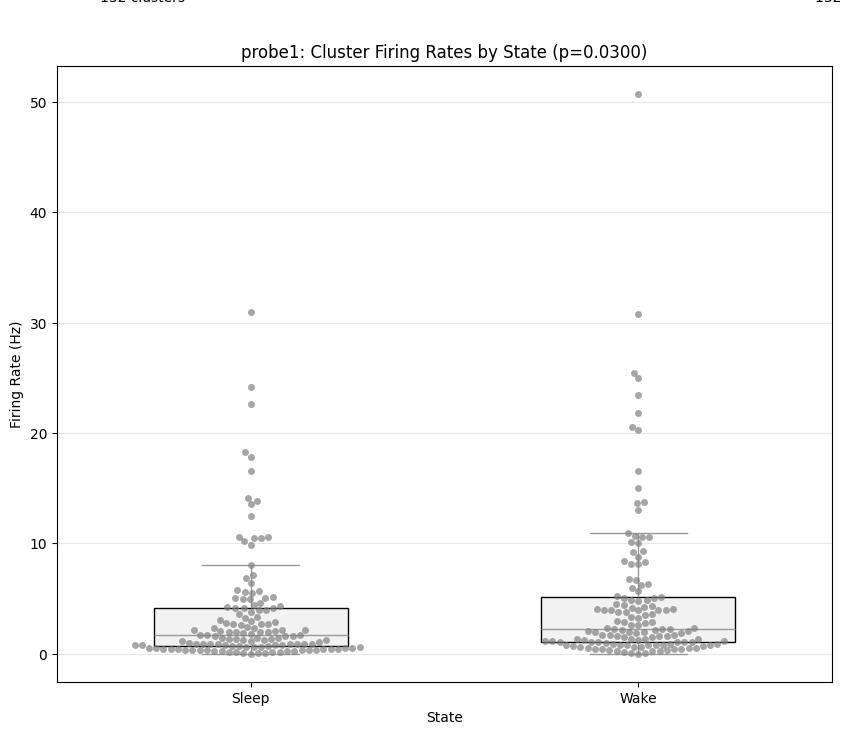

In [34]:
state_results = analyze_cluster_state_distribution(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    bin_size_s=120,
    state_threshold=90
)

Determine stability of clusters across recording
    
    Split the data into C1 and C2, semi-controlled random shuffling (random shuffle until each category has bins from both recording halves (at least 30%) and, if possible, sleep and wake data).

    1. Plot the average firing rate of each cluster in C2 vs C1
    2. Plot the average firing rate of wake-sleep in C2 vs C1


Filtered probe0: kept 149 of 310 clusters

Bin distribution for probe0:
First half sleep bins: 0
First half wake bins: 12
Second half sleep bins: 4
Second half wake bins: 3
Found balanced split after 1 iterations (0.00s)

Final bin distribution:
C1: 9 bins total, 3 sleep, 6 wake
C2: 14 bins total, 1 sleep, 9 wake

Modulation quadrant counts:
Q1 (Wake selective in both): 109
Q2 (Sleep in C1, Wake in C2): 3
Q3 (Sleep selective in both): 23
Q4 (Wake in C1, Sleep in C2): 14
Saved plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-08-08_2\DLC\neuropixel_analysis\probe0_neuronal_stability_20250527_134348.png


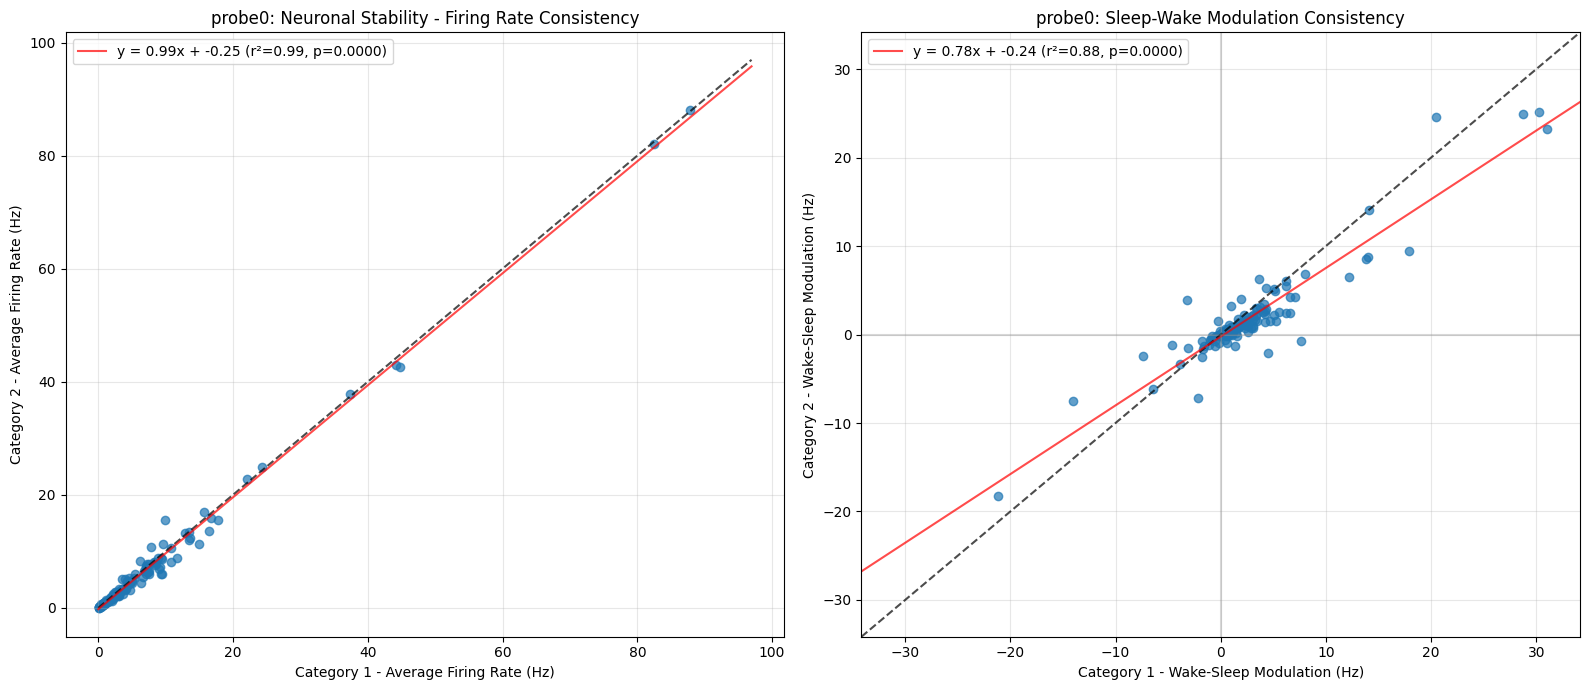


Stability metrics for probe0:
Firing rate correlation: r = 0.9961, p = 0.0000
Modulation correlation: r = 0.9388, p = 0.0000
Neurons with consistent sleep/wake preference: 88.6%
Filtered probe1: kept 132 of 268 clusters

Bin distribution for probe1:
First half sleep bins: 0
First half wake bins: 12
Second half sleep bins: 4
Second half wake bins: 3
Found balanced split after 3 iterations (0.00s)

Final bin distribution:
C1: 9 bins total, 2 sleep, 7 wake
C2: 14 bins total, 2 sleep, 8 wake

Modulation quadrant counts:
Q1 (Wake selective in both): 104
Q2 (Sleep in C1, Wake in C2): 6
Q3 (Sleep selective in both): 19
Q4 (Wake in C1, Sleep in C2): 3
Saved plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-08-08_2\DLC\neuropixel_analysis\probe1_neuronal_stability_20250527_134349.png


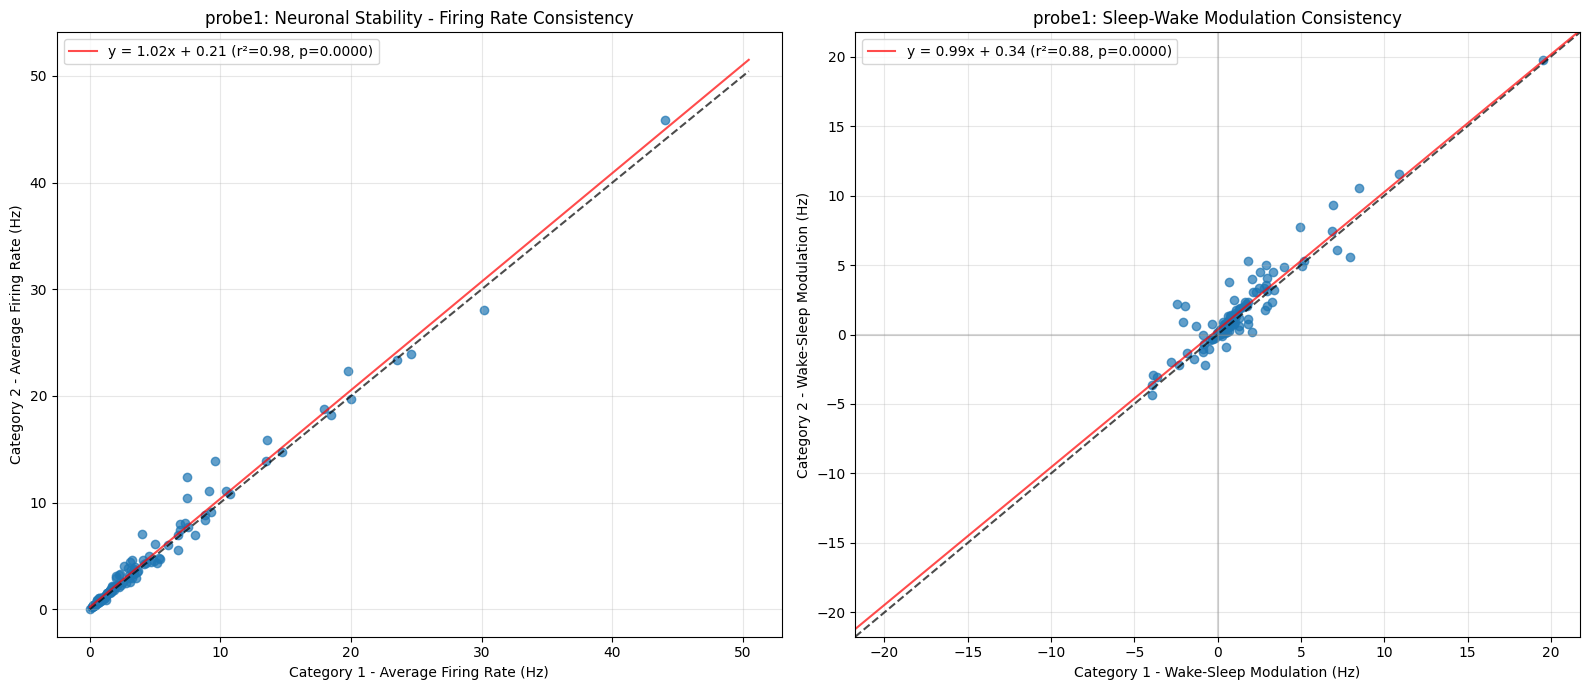


Stability metrics for probe1:
Firing rate correlation: r = 0.9912, p = 0.0000
Modulation correlation: r = 0.9399, p = 0.0000
Neurons with consistent sleep/wake preference: 93.2%


In [35]:
stability_results = analyze_neuronal_stability(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    bin_size_s=120,
    state_threshold=90,
    max_iterations=100
)

## Testing (deleted later)
